In [ ]:
# Notebook: Multi-Agent Task with LangChain OpenAI
# Author: Thomas Purk
# Date: 2025-04-16
# Reference: https://python.langchain.com/api_reference/langchain/agents/langchain.agents.agent.AgentExecutor.html#langchain.agents.agent.AgentExecutor.run

# Multi-Agent Task with LangChain OpenAI

This project demonstrates the core concepts of multi-agent orchestration. It
uses a Runnable Sequence to execute agents in a linear deterministic arrangement.

- Each agent has a role and domain-specific instruction.
- Outputs are passed from one agent to another.
- The whole system creates more value than a single LLM call.


**Token Access Required**

This Google Colab Notebook uses the built in Colab Secrets feature to supply access to the following tokens

- OpenAI

## Notebook Setup

In [1]:
# Note: uninstall and re-install with langchain-openai tied to 0.3.14 to resolve incompatibility.
!pip uninstall langchain langchain-core langchain-openai -y

Found existing installation: langchain 0.3.23
Uninstalling langchain-0.3.23:
  Successfully uninstalled langchain-0.3.23
Found existing installation: langchain-core 0.3.51
Uninstalling langchain-core-0.3.51:
  Successfully uninstalled langchain-core-0.3.51


In [2]:
!pip install --no-cache-dir --upgrade langchain langchain-core langchain-community langchain-openai==0.3.14

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.3/433.3 kB 323.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 155.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 277.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 214.5 MB/s eta 0:00:00


In [3]:
!pip list | grep "langchain\|langchain-community\|langchain-openai"

langchain                             0.3.23
langchain-community                   0.3.21
langchain-core                        0.3.53
langchain-openai                      0.3.14
langchain-text-splitters              0.3.8


In [5]:
# Setup the Notebook

# General
from google.colab import userdata
import os
import logging
#logging.getLogger("transformers").setLevel(logging.WARNING) # Suppress unnecessary logging

# Visualization & User Interface
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output

# NLP
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.agents import initialize_agent, Tool, AgentType

# Set your OpenAI API Key
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

## Models and Agents

In [6]:
# Create the Open AI Chat Object
open_ai_llm = ChatOpenAI(
    temperature=0.7,
    model_name="gpt-4o-mini"
)

In [7]:
#  Create the Researcher Agent
researcher_prompt = PromptTemplate(
    input_variables=["topic"],
    template="""
        You are a researcher. Collect factual and interesting insights about the topic:
        {topic}.
        """
)

researcher_chain = researcher_prompt | open_ai_llm

In [9]:
# Create the Writer Agent

writer_prompt = PromptTemplate(
    input_variables=["research_notes"],
    template="""
        You are a blog writer. Write a concise, informative blog post using the following research notes:
        {research_notes}
        Limit to 200 words. Make it engaging.
        """
)

writer_chain = writer_prompt | open_ai_llm

In [8]:
# Create the Reviewer Agent

reviewer_prompt = PromptTemplate(
    input_variables=["draft"],
    template="""
        You are an expert editor. Review the following blog post draft and provide constructive feedback and suggested improvements:
        {draft}
        """
)

reviewer_chain = reviewer_prompt | open_ai_llm

In [18]:
# Create a tracing function to capture the workflow stop output
tracker = {}
def tracing_function(chain, name):
    def wrapper(input_dict):
        tracker[name] = chain.invoke(input_dict)
        return tracker[name]
    return wrapper

# Add the agents chains to a tools list
tools = [
    Tool(
        name="ResearcherAgent",
        func=tracing_function(researcher_chain, "research"),
        description="Gathers information about a topic."
    ),
    Tool(
        name="WriterAgent",
        func=tracing_function(writer_chain, "draft"),
        description="Drafts a post based on the research material."
    ),
    Tool(
        name="ReviewerAgent",
        func=tracing_function(reviewer_chain, "review"),
        description="Reviews the draft research post"
    )
]

agent = initialize_agent(
    tools=tools,
    llm=open_ai_llm
)

In [27]:
# Example run
result = agent.run("Sharpening woodworking handtools using water stones")

print("\n\nFinal Output:")

print("-" * 50, "\nResearch:\n", "-" * 50 )
display(Markdown(tracker["research"].text()))

print("-" * 50, "\nDraft:\n", "-" * 50)
display(Markdown(tracker["draft"].text()))

print("-" * 50, "\nReview:\n", "-" * 50)
display(Markdown(tracker["review"].text()))




Final Output:
-------------------------------------------------- 
Research:
 --------------------------------------------------


Sharpening woodworking hand tools using water stones is a traditional and effective method that many woodworkers prefer for achieving a keen edge on their tools. Here are some factual and interesting insights about this topic:

### 1. **Types of Water Stones**:
   - **Synthetic vs. Natural**: Water stones can be either synthetic or natural. Synthetic stones are made from man-made materials and often provide consistent performance, while natural stones come from specific quarries and can exhibit unique characteristics.
   - **Grit Levels**: Water stones come in various grit levels, typically ranging from coarse (around 200-1000 grit) for shaping and repairing edges, to medium (around 1000-3000 grit) for sharpening, and fine (over 5000 grit) for honing and polishing edges to a mirror finish.

### 2. **Sharpening Process**:
   - **Soaking**: Unlike oil stones, water stones are soaked in water for about 10-15 minutes before use. This helps to create a slurry that aids in the sharpening process.
   - **Angle Consistency**: Maintaining a consistent angle (usually between 25-30 degrees for chisels and planes) is crucial for effective sharpening. Many woodworkers use jigs or guides to achieve this.
   - **Technique**: The technique often involves moving the tool in a back-and-forth or circular motion across the stone, ensuring even wear on the tool's edge.

### 3. **Benefits of Water Stones**:
   - **Fast Cutting Action**: Water stones tend to cut faster than oil stones, making the sharpening process more efficient.
   - **Ease of Use**: They are generally easier to use for beginners, as they do not require the use of any oils or special maintenance beyond regular soaking.
   - **Fine Finish**: Water stones can produce a very fine, polished edge that is desirable for woodworking tasks, resulting in cleaner cuts and finishes.

### 4. **Maintenance and Care**:
   - **Flattening**: Water stones can become uneven over time, so regular flattening is necessary. This can be done using a flattening stone or a diamond plate.
   - **Storage**: It's best to store water stones in a dry place to prevent them from becoming too soft or damaged. They can be stored in a plastic container or a wooden box to protect them.

### 5. **Environmental Considerations**:
   - **Sustainability**: Natural water stones are a sustainable resource when sourced responsibly. However, synthetic stones can be made from materials that may not be environmentally friendly.
   - **Water Usage**: The use of water stones can require more water than oil stones, leading to considerations about water usage in certain regions.

### 6. **Cultural Significance**:
   - Water stones, particularly Japanese water stones (like the famous Shapton and Naniwa stones), hold significant cultural importance in woodworking traditions, reflecting craftsmanship and precision.
   - They are often celebrated in woodworking communities for their effectiveness and the skill required to use them properly, linking the act of sharpening to the broader practice of craftsmanship.

### 7. **Learning Curve**:
   - Although they are user-friendly, mastering the use of water stones takes practice. Experienced woodworkers often have personal preferences regarding the types of stones and techniques that work best for them.

### 8. **Comparison with Other Sharpening Methods**:
   - Water stones are often compared with oil stones and diamond plates. Each method has its pros and cons, but many woodworkers favor water stones for their ability to produce a fine edge and the ease of cleanup.

### Conclusion:
Sharpening woodworking hand tools with water stones is a blend of art and science. It requires knowledge of materials and techniques, but the results can greatly enhance the performance of hand tools, leading to more enjoyable and efficient woodworking experiences. As woodworking continues to gain popularity, the use of water stones remains a respected tradition that combines heritage with practical skill.

-------------------------------------------------- 
Draft:
 --------------------------------------------------


### Mastering the Art of Sharpening Woodworking Tools with Water Stones

Sharpening woodworking tools with water stones is a cherished technique among woodworkers, revered for delivering razor-sharp edges. Available in both synthetic and natural forms, these stones range from coarse (200-1000 grit) for shaping to fine (over 5000 grit) for polishing.

Start by soaking your water stone for 10-15 minutes to create a slurry that enhances cutting efficiency. Maintaining a consistent angle of 25-30 degrees is essential; many woodworkers use jigs for precision. This careful process results in a polished edge that can elevate your woodworking projects.

Water stones are favored for their fast cutting action and user-friendliness, making them perfect for beginners. However, they do require maintenance—regular flattening and careful storage are key. Rinse and dry your stone after each use to keep it in top shape.

Richly embedded in cultural traditions, especially in Japanese woodworking, water stones highlight the artisan's skill. While other sharpening methods exist, none quite match the exceptional edges and minimal cleanup that water stones provide.

### Conclusion
Embark on your sharpening journey by honing a chisel or plane blade. Share your experiences in the comments, and subscribe for more woodworking insights!

-------------------------------------------------- 
Review:
 --------------------------------------------------


Your blog post draft on sharpening woodworking hand tools using water stones is informative and well-structured. Here are some constructive feedback and suggestions for improvement:

### Title
- **Suggestion**: Consider making the title more engaging. For example, "Mastering the Art of Sharpening Woodworking Tools with Water Stones" adds a sense of skill and mastery.

### Introduction
- **Strength**: The introduction effectively outlines the importance of water stones in woodworking.
- **Improvement**: You might want to add a brief anecdote or a quote from a famous woodworker to draw readers in more personally. 

### Content Clarity
- **Strength**: You provide a good overview of the types of water stones and their uses.
- **Improvement**: It may help to briefly explain what grit levels mean for those unfamiliar with sharpening tools. For example:
  - "Coarse grits (200-1000) are used for shaping and removing material quickly, while fine grits (over 5000) refine the edge for a polished finish."

### Technical Details
- **Strength**: You mention the importance of angle and the use of jigs.
- **Improvement**: Consider providing a little more detail about how to maintain the angle or examples of jigs that are effective. A link to recommended products or further resources could be beneficial.

### Maintenance Section
- **Suggestion**: Expand on the maintenance of water stones. You could include tips such as:
  - "After each use, it’s advisable to rinse the stone with clean water and dry it thoroughly before storage."
  - "Flattening stones can be done using a flat surface and a coarse grit stone for effective results."

### Cultural Significance
- **Strength**: The mention of cultural significance adds depth to your post.
- **Improvement**: You might elaborate on the specific Japanese techniques or traditions related to water stones. This could attract readers interested in cultural aspects of woodworking.

### Conclusion
- **Strength**: The conclusion summarizes the benefits of using water stones effectively.
- **Improvement**: You could also encourage readers to practice by providing a simple step-by-step guide on how to sharpen a specific tool (e.g., a chisel or plane blade) using water stones.

### Overall Suggestions
- **Visuals**: Consider including images or diagrams of the sharpening process, different types of water stones, or even the end results. Visual aids can greatly enhance understanding and engagement.
- **Call to Action**: End with a call to action, inviting readers to share their experiences with water stones in the comments or to subscribe for more woodworking tips.

### Final Thought
Overall, your draft is strong, with just a few areas for enhancement. By adding more detail, examples, and visuals, you can create a richer, more engaging post that will resonate with both novice and experienced woodworkers. Great work!

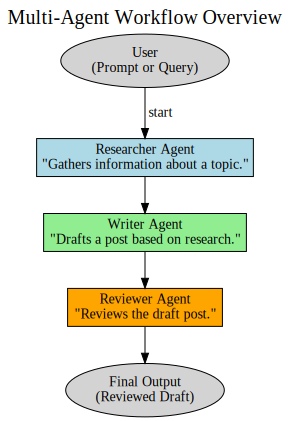

In [41]:
from graphviz import Digraph

# Initialize the graph
dot = Digraph(comment='Multi-Agent Workflow')
dot.attr(label='Multi-Agent Workflow Overview', fontsize='20', labelloc='t')


# Nodes: Represent each agent
dot.node('User', 'User\n(Prompt or Query)', shape='oval', style='filled', fillcolor='lightgray')
dot.node('ResearcherAgent', 'Researcher Agent\n"Gathers information about a topic."', shape='box', style='filled', fillcolor='lightblue')
dot.node('WriterAgent', 'Writer Agent\n"Drafts a post based on research."', shape='box', style='filled', fillcolor='lightgreen')
dot.node('ReviewerAgent', 'Reviewer Agent\n"Reviews the draft post."', shape='box', style='filled', fillcolor='orange')
dot.node('Output', 'Final Output\n(Reviewed Draft)', shape='oval', style='filled', fillcolor='lightgray')

# Edges: Represent the flow
dot.edge('User', 'ResearcherAgent', label='  start')
dot.edge('ResearcherAgent', 'WriterAgent')
dot.edge('WriterAgent', 'ReviewerAgent')
dot.edge('ReviewerAgent', 'Output')

# Render graph
display(dot)


In [35]:
!pwd

/content
